In [76]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import urllib.request
import zipfile
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

In [77]:
url = 'https://github.com/dekwannn/wastemanagement/archive/refs/heads/main.zip'
zip_path = 'dataset-resized.zip'
extract_path = 'dataset-resized'

# Download the dataset zip file
urllib.request.urlretrieve(url, zip_path)

# Unzip the downloaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define the new data directory after extraction
data_dir = os.path.join(extract_path, 'wastemanagement-main/ML/backup_data/dataset-resized')

In [51]:
# Create a list of filepaths and labels
filepaths = []
labels = []
classlist = os.listdir(data_dir)
for kelass in classlist:
    classpath = os.path.join(data_dir, kelass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(kelass)

# Create a DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

print(df.head())
print(df['labels'].value_counts())

                                           filepaths       labels
0  dataset-resized/wastemanagementapk-main/ML/bac...  non_recycle
1  dataset-resized/wastemanagementapk-main/ML/bac...  non_recycle
2  dataset-resized/wastemanagementapk-main/ML/bac...  non_recycle
3  dataset-resized/wastemanagementapk-main/ML/bac...  non_recycle
4  dataset-resized/wastemanagementapk-main/ML/bac...  non_recycle
labels
shoes          1977
glass          1905
clothes        1865
paper          1644
plastic        1347
cardboard      1294
metal          1179
biological      985
battery         945
non_recycle     834
Name: count, dtype: int64


In [52]:
# Splitting data into train, validation, and test sets
train_split = .8
test_split = .1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))


train_df length: 11180 test_df length: 1397 valid_df length: 1398


In [53]:
# Preprocessing dataset
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

test batch size: 11 test steps: 127


In [54]:
#augmentation
gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

Found 11180 validated image filenames belonging to 10 classes.
Found 1398 validated image filenames belonging to 10 classes.
Found 1397 validated image filenames belonging to 10 classes.
['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'non_recycle', 'paper', 'plastic', 'shoes']


In [55]:
# Image augmentation
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [56]:
#buat generator untuk train, valid, test
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 11180 validated image filenames belonging to 10 classes.
Found 1398 validated image filenames belonging to 10 classes.
Found 1397 validated image filenames belonging to 10 classes.


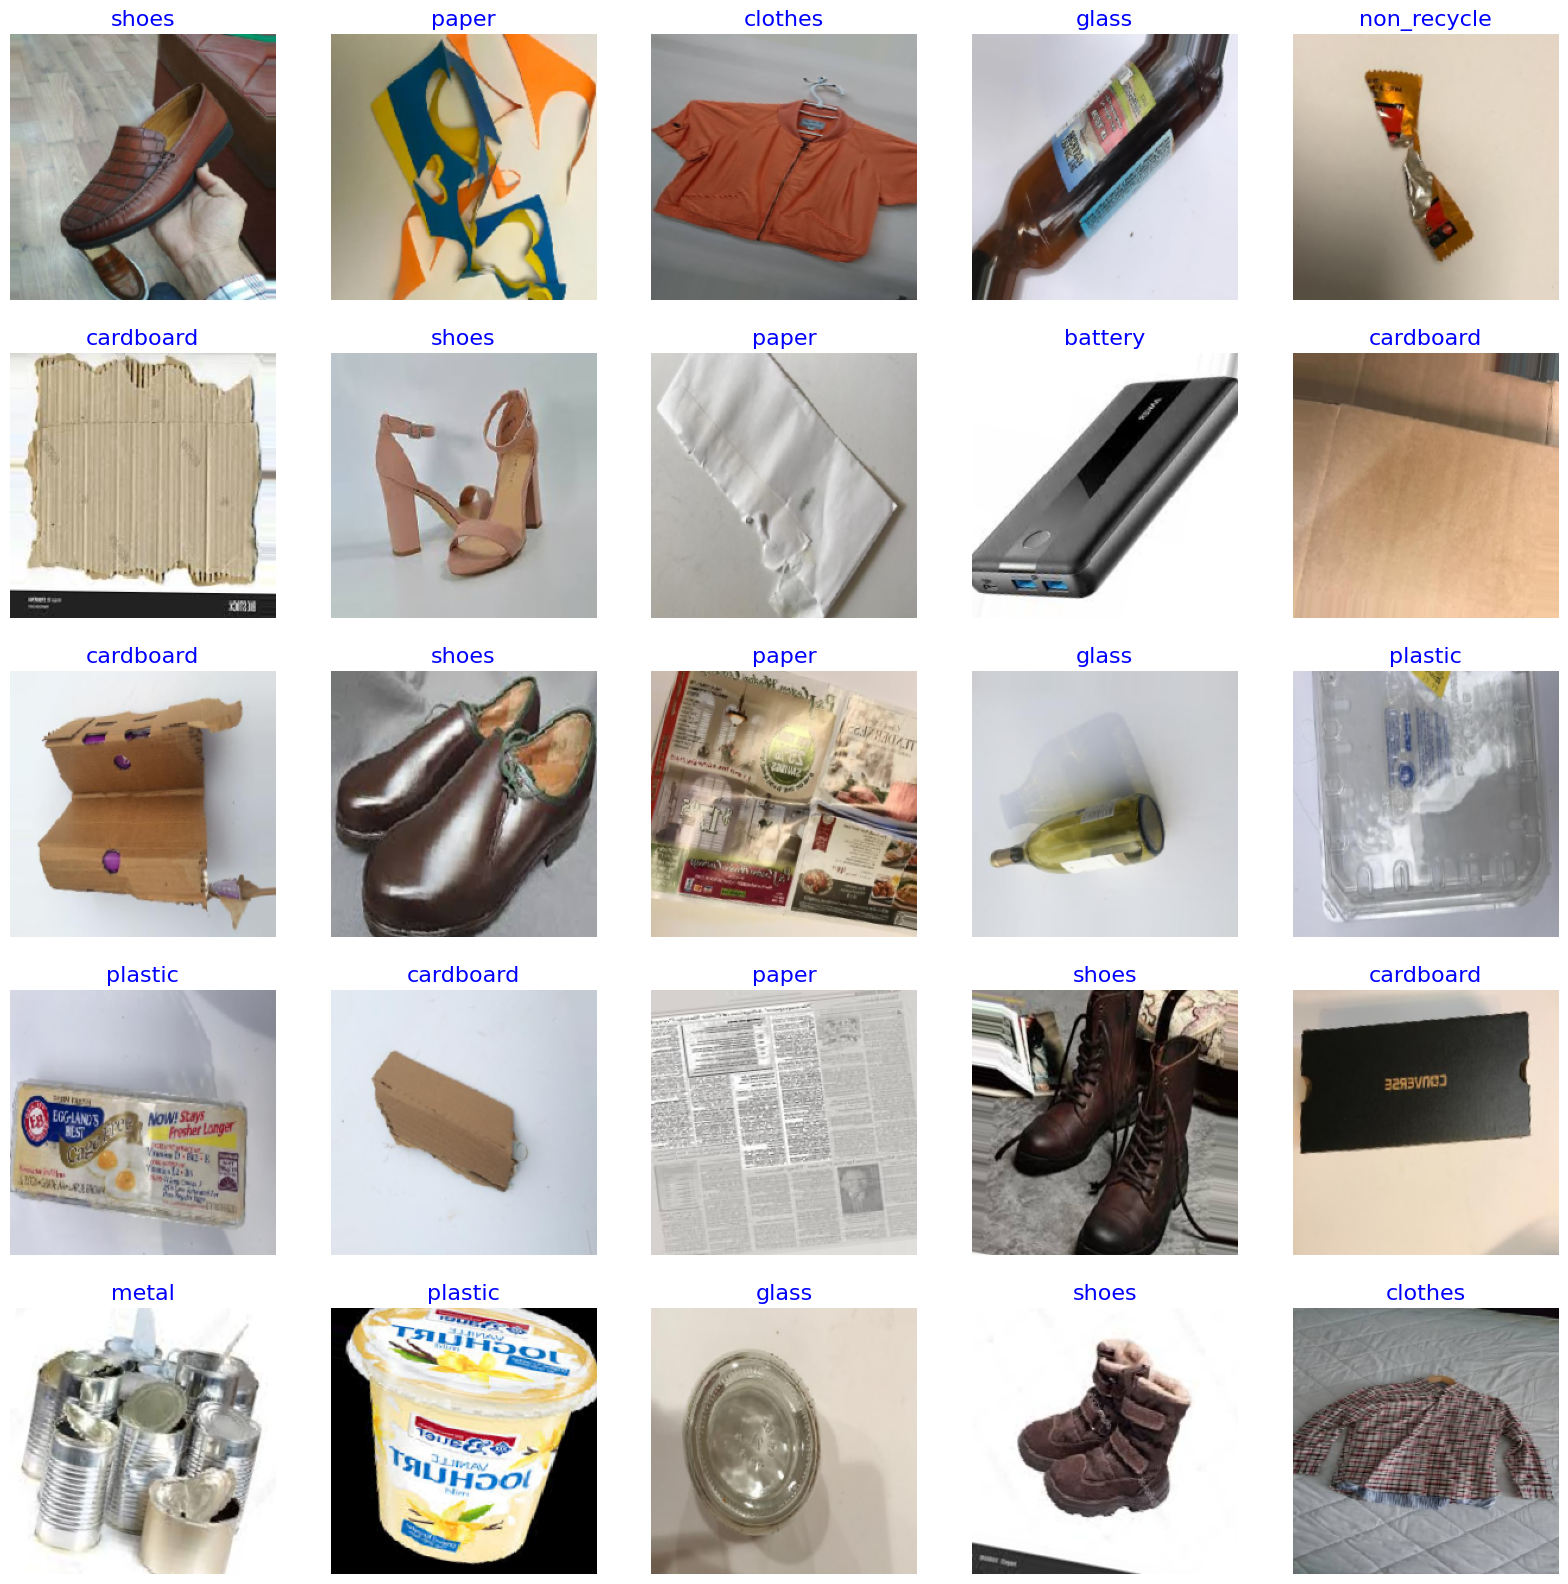

In [57]:
# Visualizing some sample images
def show_image_samples(gen):
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [58]:
# Definisiin extractor dan compile model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

# Build the model
model = Sequential([
    extractor,  # Feature extractor
    Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Call build() method to build the model
model.build((None, 224, 224, 3))

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 7, 7, 160)         1364864   
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          46112     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 64)         

In [60]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping, checkpoint])

Epoch 1/20
175/175 [==============================] - 150s 853ms/step - loss: 0.6967 - accuracy: 0.7674 - val_loss: 0.5849 - val_accuracy: 0.8019
Epoch 2/20
175/175 [==============================] - 151s 865ms/step - loss: 0.6212 - accuracy: 0.7914 - val_loss: 0.5397 - val_accuracy: 0.8155
Epoch 3/20
175/175 [==============================] - 149s 850ms/step - loss: 0.5672 - accuracy: 0.8110 - val_loss: 0.5002 - val_accuracy: 0.8298
Epoch 4/20
175/175 [==============================] - 151s 860ms/step - loss: 0.5256 - accuracy: 0.8268 - val_loss: 0.4765 - val_accuracy: 0.8383
Epoch 5/20
175/175 [==============================] - 146s 835ms/step - loss: 0.4957 - accuracy: 0.8336 - val_loss: 0.4737 - val_accuracy: 0.8312
Epoch 6/20
175/175 [==============================] - 150s 856ms/step - loss: 0.4516 - accuracy: 0.8500 - val_loss: 0.4538 - val_accuracy: 0.8455
Epoch 7/20
175/175 [==============================] - 148s 846ms/step - loss: 0.4274 - accuracy: 0.8616 - val_loss: 0.4410 -

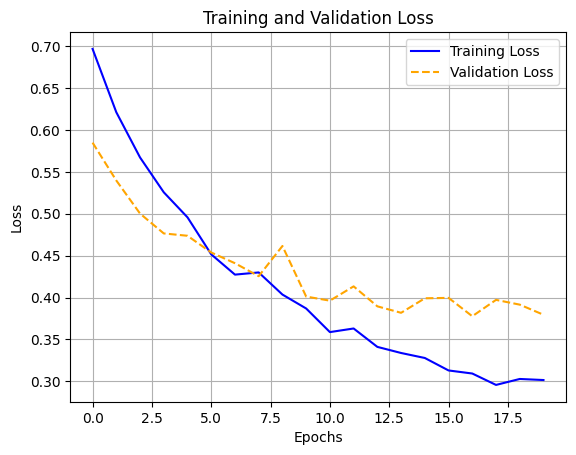

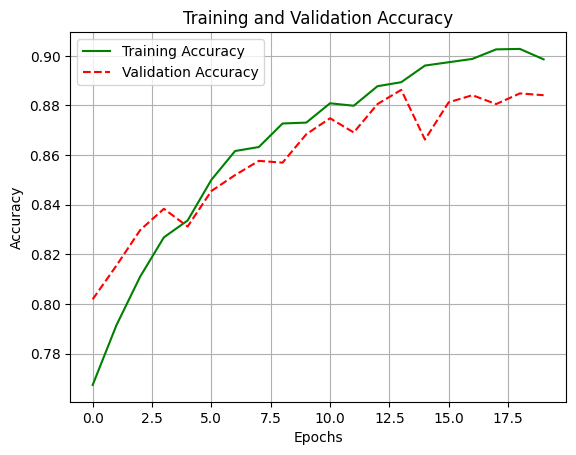

In [61]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Save the trained model as HDF5 file
model.save('my_model.keras')

In [63]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [70]:
from tensorflow.keras.preprocessing import image


# Define the classes
classes = ["BATTERY", "BIOLOGICAL", "CLOTHES", "CARDBOARD", "GLASS", "METAL", "PAPER", "PLASTIC", "NON_RECYCLE","SHOES" ]


In [71]:
# Function to preprocess the image
def preprocess_image(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array = img_array / 255.0  # Rescale image
    return img_array

In [72]:
# Function to predict the class of the image
def predict_image_class(model, img):
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    class_name = classes[predicted_class[0]]
    confidence = np.max(predictions) * 100
    return class_name, confidence

In [73]:
# Function to display the image with predicted class and confidence
def display_prediction(img, class_name, confidence):
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

In [74]:
# Create a file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    # Get the uploaded file
    file = next(iter(upload_widget.value.values()))
    content = file['content']

    # Open the image
    img = Image.open(io.BytesIO(content))

    # Predict the class of the image
    class_name, confidence = predict_image_class(model, img)

    # Display the image and prediction
    display_prediction(img, class_name, confidence)

FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 0s 25ms/step


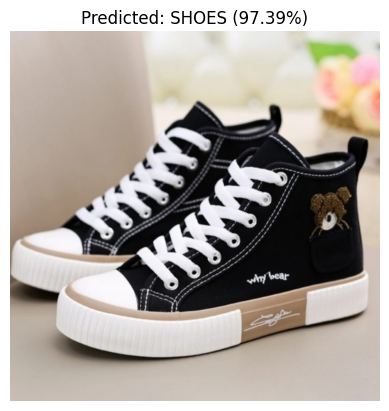

1/1 [==============================] - 0s 23ms/step


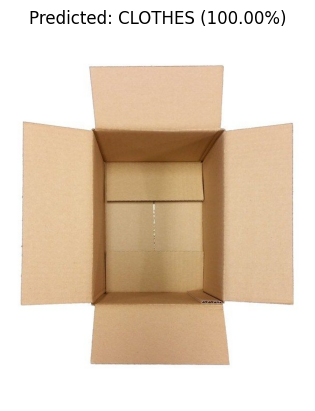

1/1 [==============================] - 0s 23ms/step


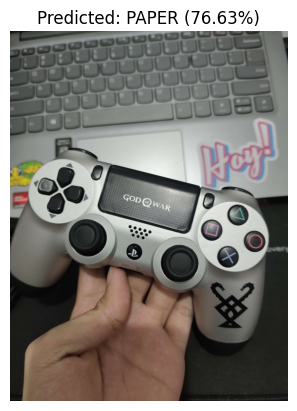

1/1 [==============================] - 0s 24ms/step


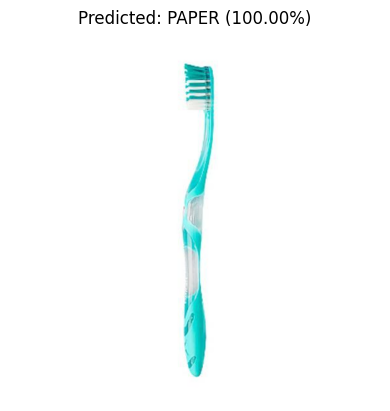

In [75]:
# Observe the upload widget for changes
upload_widget.observe(on_upload_change, names='value')

# Display the upload widget
display(upload_widget)